<a href="https://colab.research.google.com/github/prayas99/Named-Entity-Recognition-on-Conll-2003-dataset-using-Python/blob/main/Named_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import KFold
import nltk
from math import log
import time
from sklearn.svm import SVC
from sklearn.metrics import  classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Feature extraction

In [ ]:
def feature_extraction(sentence): # tokenized sentence
  m=len(sentence)
  pos_list=[x[1] for x in pos_tag(sentence)]
  features=[[] for i in range(m)]
  #NEI_label(ner_tags[0])
  for i in range(m):
    curr_word=sentence[i]
    #print(curr_word)
    #print()
    # length of word
    features[i].append(len(curr_word))
    # isFirstUpper
    if curr_word[0].isupper():
      features[i].append(1)
    else:
      features[i].append(0)
    # isAllUpper
    if curr_word.isupper():
      features[i].append(1)
    else:
      features[i].append(0)
    # isNounPos
    if pos_list[i].startswith('N'):
      features[i].append(1)
    else:
      features[i].append(0)  
    # isTitle
    if curr_word.istitle(): 
          features[i].append(1)
          # if not curr_word[0].isupper(): 
          #   print(curr_word, pos_list[i])
          #   print()
    else:
          features[i].append(0)
    # previous tokens
    if i > 0:
        prv_word = sentence[i-1][0]
        if prv_word.isupper():
          features[i].append(1)
        else:
          features[i].append(0)  
        if prv_word.istitle(): 
          features[i].append(1)
        else:
          features[i].append(0)  
    else:
        features[i].append(2)
        features[i].append(2)
    # next tokens
    if i < m-1:
        nxt_word = sentence[i+1][0]
        if nxt_word.isupper():
          features[i].append(1)
        else:
          features[i].append(0)  
        if nxt_word.istitle(): 
          features[i].append(1)
        else:
          features[i].append(0)
    else:
        features[i].append(-1)
        features[i].append(-1)
    # bias
    features[i].append(1)
    
  return np.array(features)

def NEI_label(ner_tags):
  return (np.array(ner_tags)>0).astype(int)   

# Dataset

In [ ]:
!pip install datasets

     |████████████████████████████████| 290 kB 4.0 MB/s 
     |████████████████████████████████| 243 kB 54.5 MB/s 
     |████████████████████████████████| 59 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 45.2 MB/s 
     |████████████████████████████████| 125 kB 75.6 MB/s 
     |████████████████████████████████| 160 kB 72.0 MB/s 
     |████████████████████████████████| 192 kB 74.4 MB/s 
     |████████████████████████████████| 271 kB 72.8 MB/s 


In [ ]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

Downloading:   0%|          | 0.00/2.60k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/650k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/146k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Dataset Visualization

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
dataset['train']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

In [ ]:
dataset['train'].features

{'chunk_tags': Sequence(feature=ClassLabel(num_classes=23, names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], names_file=None, id=None), length=-1, id=None),
 'id': Value(dtype='string', id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], names_file=None, id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(num_classes=47, names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], names_file=None, id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value

In [ ]:
print(dataset['train']['tokens'][13])
print(dataset['train']['ner_tags'][13])

['The', 'EU', "'s", 'scientific', 'veterinary', 'and', 'multidisciplinary', 'committees', 'are', 'due', 'to', 're-examine', 'the', 'issue', 'early', 'next', 'month', 'and', 'make', 'recommendations', 'to', 'the', 'senior', 'veterinary', 'officials', '.']
[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
from nltk import pos_tag

In [ ]:
n=len(dataset['train'])
n

14041

# Model

In [ ]:
SVM_classifier=SVC(C=1.0,gamma='auto',kernel='rbf',class_weight='balanced')

In [ ]:
SVM_classifier

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Training

In [ ]:
sentences=dataset['train']['tokens']
ner_tags=dataset['train']['ner_tags']
start=time.time()
train_X=feature_extraction(sentences[0])
train_y= NEI_label(ner_tags[0])
for i in range(1,n):
  #print(i)
  train_X=np.concatenate((train_X,feature_extraction(sentences[i])),axis=0)
  train_y=np.concatenate((train_y,NEI_label(ner_tags[i])),axis=0)
print(time.time()-start)

64.34015703201294


In [ ]:
print(np.shape(train_X))
print(np.shape(train_y))

(203621, 10)
(203621,)


In [ ]:
train_X, data_test, train_y, labels_test = train_test_split(train_X, train_y, test_size=0.60, random_state=42)

In [ ]:
print(np.shape(train_X))
print(np.shape(train_y))

(81448, 10)
(81448,)


In [ ]:
y_count = Counter(train_y)
print('Total:', y_count[0] + y_count[1])
print('Sample rate:', round(y_count[1]/(y_count[0] + y_count[1]),3))
print('Positive:', y_count[1])

Total: 81448
Sample rate: 0.167
Positive: 13599


In [ ]:
sc = StandardScaler()
train_X = sc.fit_transform(train_X)

In [ ]:
start=time.time()
SVM_classifier.fit(train_X,train_y)
print(time.time()-start)

112.96335935592651


In [ ]:
features_names = ['length', 'firstUpper',
                  'allUpper', 'posNoun',
                  'isTitle', 'prvUpper',
                  'prvTitle', 'nxtUpper',
                  'nxtTitle', 'bias']

In [ ]:
print(classification_report(train_y,SVM_classifier.predict(train_X)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     67849
           1       0.80      0.98      0.88     13599

    accuracy                           0.96     81448
   macro avg       0.90      0.96      0.93     81448
weighted avg       0.96      0.96      0.96     81448



In [ ]:
dataset['validation']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 3250
})

In [ ]:
val_sentences=dataset['validation']['tokens']
val_nertags=dataset['validation']['ner_tags']
start=time.time()
val_X=feature_extraction(val_sentences[0])
val_y= NEI_label(val_nertags[0])
for i in range(1,len(dataset['validation'])):
  val_X=np.concatenate((val_X,feature_extraction(val_sentences[i])),axis=0)
  val_y=np.concatenate((val_y,NEI_label(val_nertags[i])),axis=0)
print(time.time()-start)

4.196402549743652


In [ ]:
val_X = sc.transform(val_X)

In [ ]:
print(classification_report(val_y,SVM_classifier.predict(val_X)))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     42759
           1       0.81      0.97      0.88      8603

    accuracy                           0.96     51362
   macro avg       0.90      0.96      0.93     51362
weighted avg       0.96      0.96      0.96     51362



In [ ]:
print(confusion_matrix(val_y,SVM_classifier.predict(val_X)))

[[40790  1969]
 [  237  8366]]


Text(0.5, 0, 'Permutation Importance')

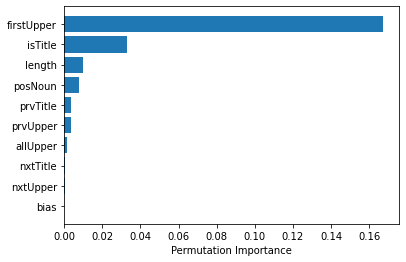

In [ ]:
perm_importance = permutation_importance(SVM_classifier, val_X, val_y)

features = np.array(features_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

# Testing

In [ ]:
test_sentences=dataset['test']['tokens']
test_nertags=dataset['test']['ner_tags']
start=time.time()
test_X=feature_extraction(test_sentences[0])
test_y= NEI_label(test_nertags[0])
for i in range(1,len(dataset['test'])):
  test_X=np.concatenate((test_X,feature_extraction(test_sentences[i])),axis=0)
  test_y=np.concatenate((test_y,NEI_label(test_nertags[i])),axis=0)
print(time.time()-start)

4.252490758895874


In [ ]:
test_X = sc.transform(test_X)

In [ ]:
print(classification_report(test_y,SVM_classifier.predict(test_X)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     38323
           1       0.78      0.98      0.87      8112

    accuracy                           0.95     46435
   macro avg       0.89      0.96      0.92     46435
weighted avg       0.96      0.95      0.95     46435



# Saving Model

In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(SVM_classifier, open('finalized_model.pkl', 'wb'))
pickle.dump(sc, open('scaler.pkl', 'wb'))

# User input

In [ ]:
given_sent = [str(input())]

The State Bank of India is the largest bank in the country


In [ ]:
from nltk.tokenize import word_tokenize
tokenized_sents = [word_tokenize(i) for i in given_sent]

In [ ]:
tokenized_sents

[['The',
  'State',
  'Bank',
  'of',
  'India',
  'is',
  'the',
  'largest',
  'bank',
  'in',
  'the',
  'country']]

In [ ]:
import pickle
SVM_classifier = pickle.load(open('finalized_model.pkl', 'rb'))
sc = pickle.load(open('scaler.pkl', 'rb'))

In [ ]:
test_X = feature_extraction(tokenized_sents[0])
test_X = sc.transform(test_X)
SVM_classifier.predict(test_X).tolist()

[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

# Test on given sents

In [ ]:
test_sent = []
test_sent.append("The State Bank of India is the largest bank in the country")
test_sent.append("Pushpak Bhattacharyya teaches us CS626")
test_sent.append("India got its freedom on 15th August 1947")
test_sent.append("India got its freedom on 15-8-1947")
test_sent.append("India got its freedom on 15/8/1947")
test_sent.append("India got its freedom on 15.8.194")

In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize
tokenized_sents = [word_tokenize(i) for i in test_sent]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
start=time.time()
for i in range(0,len(tokenized_sents)):
  test_X=feature_extraction(tokenized_sents[i])
  print(SVM_classifier.predict(test_X))
print(time.time()-start)

[1 1 1 0 1 0 0 0 0 0 0 0]
[1 0 0 0 1]
[1 0 0 0 0 0 1 0]
[1 0 0 0 0 0]
[1 0 0 0 0 0]
[1 0 0 0 0 0]
0.030510663986206055
